# Reconstructs a video based on pretrained reconstructor model

In [26]:
#initialise
# needs work separating input videos and whatnot
import extractor
extractor.main()
fps = extractor.fps
resolution = extractor.resolution

FPS: 30.0
Resolution: 640x360
Audio extracted to output_data/audio.mp3
Extracted 1146 frames.
Feature data has been collected!
Writing data to csv
Features saved to output_data/output_features.csv
Extraction completed!


In [27]:
from joblib import load
model = load('model/video_reconstructor_model.joblib')

In [28]:
import numpy as np
import pandas as pd

In [29]:
import pydub

df = pd.read_csv('output_data/output_features.csv')
df['frame_index'] = df.index
df['normalized_index']=df['frame_index']/len(df)

audio_full = pydub.AudioSegment.from_mp3('output_data/audio.mp3')

slice_paths = []

for i in range(len(df['timestamp'])):
    frame_start = df['timestamp'][i]
    if i >= len(df['timestamp'])-1:
        frame_end = len(audio_full)
    else:
        frame_end = df['timestamp'][(i+1)]
    slice:pydub.AudioSegment = audio_full[frame_start:frame_end]
    slice_path = f'output_slices/audio_slice_{frame_start*0.001}_{i}.wav'
    slice.export(slice_path, format='wav')
    slice_paths.append(slice_path)

df['audio_slice_path'] = slice_paths
print(df.head())

   timestamp                      frame_filename  hist_bin_0  hist_bin_1  \
0          0    output_frames/frame_0_time_0.jpg    0.015574    0.005626   
1         33   output_frames/frame_1_time_33.jpg    0.014841    0.005619   
2         66   output_frames/frame_2_time_66.jpg    0.016126    0.006294   
3        100  output_frames/frame_3_time_100.jpg    0.014532    0.006829   
4        133  output_frames/frame_4_time_133.jpg    0.016952    0.007067   

   hist_bin_2  hist_bin_3  hist_bin_4  hist_bin_5  hist_bin_6  hist_bin_7  \
0    0.001219    0.004434    0.002342    0.000790    0.000540    0.000222   
1    0.001433    0.003867    0.001878    0.000709    0.000556    0.000111   
2    0.001833    0.004746    0.001634    0.000682    0.000455    0.000114   
3    0.001820    0.004747    0.001893    0.000713    0.000495    0.000087   
4    0.001700    0.005949    0.002192    0.001073    0.000552    0.000000   

   ...  edge_993  edge_994  edge_995  edge_996  edge_997  edge_998  edge_999  \


In [30]:
X = df.drop(['timestamp', 'frame_filename'], axis=1)

In [31]:
import json

with open('output_data/used_feature_columns.json') as f:
    used_columns = json.load(f)

# filter out unused features

X = X[used_columns]

In [32]:
y_pred = model.predict(X)
df['predicted_position'] = y_pred
df_sorted = df.sort_values('predicted_position')


In [33]:
import cv2

output_video = cv2.VideoWriter('output_data/reconstructed.avi',
                               cv2.VideoWriter_fourcc(*'XVID'),
                               fps,
                               resolution)  


for _, row in df_sorted.iterrows():
    frame = cv2.imread(row['frame_filename'])
    output_video.write(frame)

output_video.release()
print("Reconstructed Video Saved!!")

Reconstructed Video Saved!!


In [34]:
print(df.head())

final_audio:pydub.AudioSegment = pydub.AudioSegment.empty()
for s in df_sorted['audio_slice_path']:
    sorted_slice = pydub.AudioSegment.from_wav(s)
    final_audio = final_audio.append(sorted_slice, crossfade=0)
final_audio.export('output_data/final_audio.mp3')

   timestamp                      frame_filename  hist_bin_0  hist_bin_1  \
0          0    output_frames/frame_0_time_0.jpg    0.015574    0.005626   
1         33   output_frames/frame_1_time_33.jpg    0.014841    0.005619   
2         66   output_frames/frame_2_time_66.jpg    0.016126    0.006294   
3        100  output_frames/frame_3_time_100.jpg    0.014532    0.006829   
4        133  output_frames/frame_4_time_133.jpg    0.016952    0.007067   

   hist_bin_2  hist_bin_3  hist_bin_4  hist_bin_5  hist_bin_6  hist_bin_7  \
0    0.001219    0.004434    0.002342    0.000790    0.000540    0.000222   
1    0.001433    0.003867    0.001878    0.000709    0.000556    0.000111   
2    0.001833    0.004746    0.001634    0.000682    0.000455    0.000114   
3    0.001820    0.004747    0.001893    0.000713    0.000495    0.000087   
4    0.001700    0.005949    0.002192    0.001073    0.000552    0.000000   

   ...  edge_994  edge_995  edge_996  edge_997  edge_998  edge_999  \
0  ...    

<_io.BufferedRandom name='output_data/final_audio.mp3'>

In [35]:
import subprocess

def combine_audio_video(reconstructed_video, audio_file, output_video):
    command = ['ffmpeg', '-i', reconstructed_video, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', output_video, '-y']
    subprocess.run(command, check=True)
    print(f"Final video saved to {output_video}")

combine_audio_video('output_data/reconstructed.avi', 'output_data/final_audio.mp3','output_data/final_output.mp4')

Final video saved to output_data/final_output.mp4


['hist_bin_144', 'edge_938', 'edge_940', 'edge_941', 'edge_939', 'edge_942', 'edge_904', 'edge_907', 'edge_306', 'edge_908', 'edge_906', 'edge_937', 'edge_379', 'edge_898', 'edge_897', 'edge_901', 'edge_913', 'edge_899', 'edge_903', 'edge_909', 'edge_902', 'edge_917', 'edge_895', 'hist_bin_155', 'hist_bin_156', 'edge_912', 'edge_273', 'edge_900', 'edge_257', 'hist_bin_209', 'hist_bin_148', 'hist_bin_147', 'edge_916', 'edge_914', 'hist_bin_75', 'edge_911', 'edge_920', 'edge_918', 'hist_bin_289', 'edge_921', 'edge_919', 'edge_272', 'hist_bin_65', 'hist_bin_220', 'hist_bin_362', 'edge_922', 'hist_bin_228', 'edge_923', 'hist_bin_221', 'edge_929', 'hist_bin_212', 'hist_bin_138', 'hist_bin_69', 'hist_bin_139', 'edge_926', 'edge_936', 'edge_928', 'hist_bin_146', 'hist_bin_157', 'hist_bin_361', 'hist_bin_80', 'hist_bin_67', 'edge_930', 'edge_931', 'edge_927', 'hist_bin_293', 'hist_bin_213', 'hist_bin_288', 'hist_bin_280', 'edge_932', 'hist_bin_66', 'hist_bin_136', 'hist_bin_140', 'hist_bin_82'

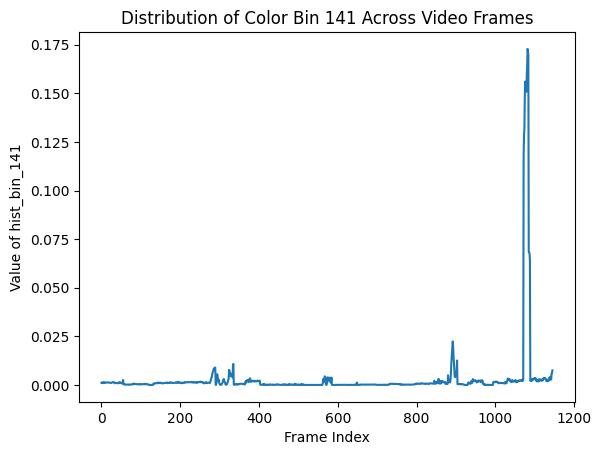

In [36]:
# debug
print(X.columns.to_list())

import matplotlib.pyplot as plt
plt.plot(df['frame_index'], df['hist_bin_141'])
plt.xlabel('Frame Index')
plt.ylabel('Value of hist_bin_141')
plt.title('Distribution of Color Bin 141 Across Video Frames')
plt.show()

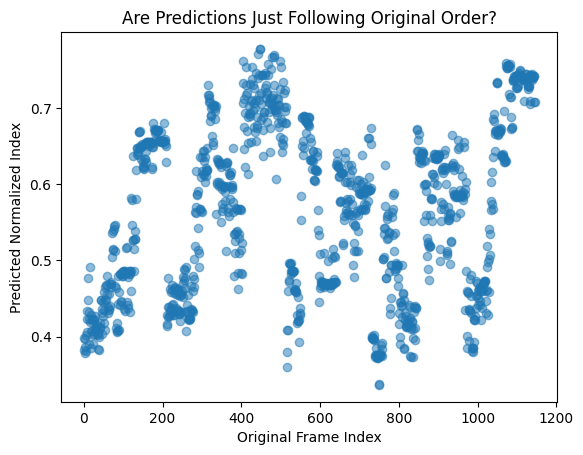

In [37]:
plt.scatter(df['frame_index'], df['predicted_position'], alpha=0.5)
plt.xlabel("Original Frame Index")
plt.ylabel("Predicted Normalized Index")
plt.title("Are Predictions Just Following Original Order?")
plt.show()
